# Train a Neural Network to Predict Quality of Wine
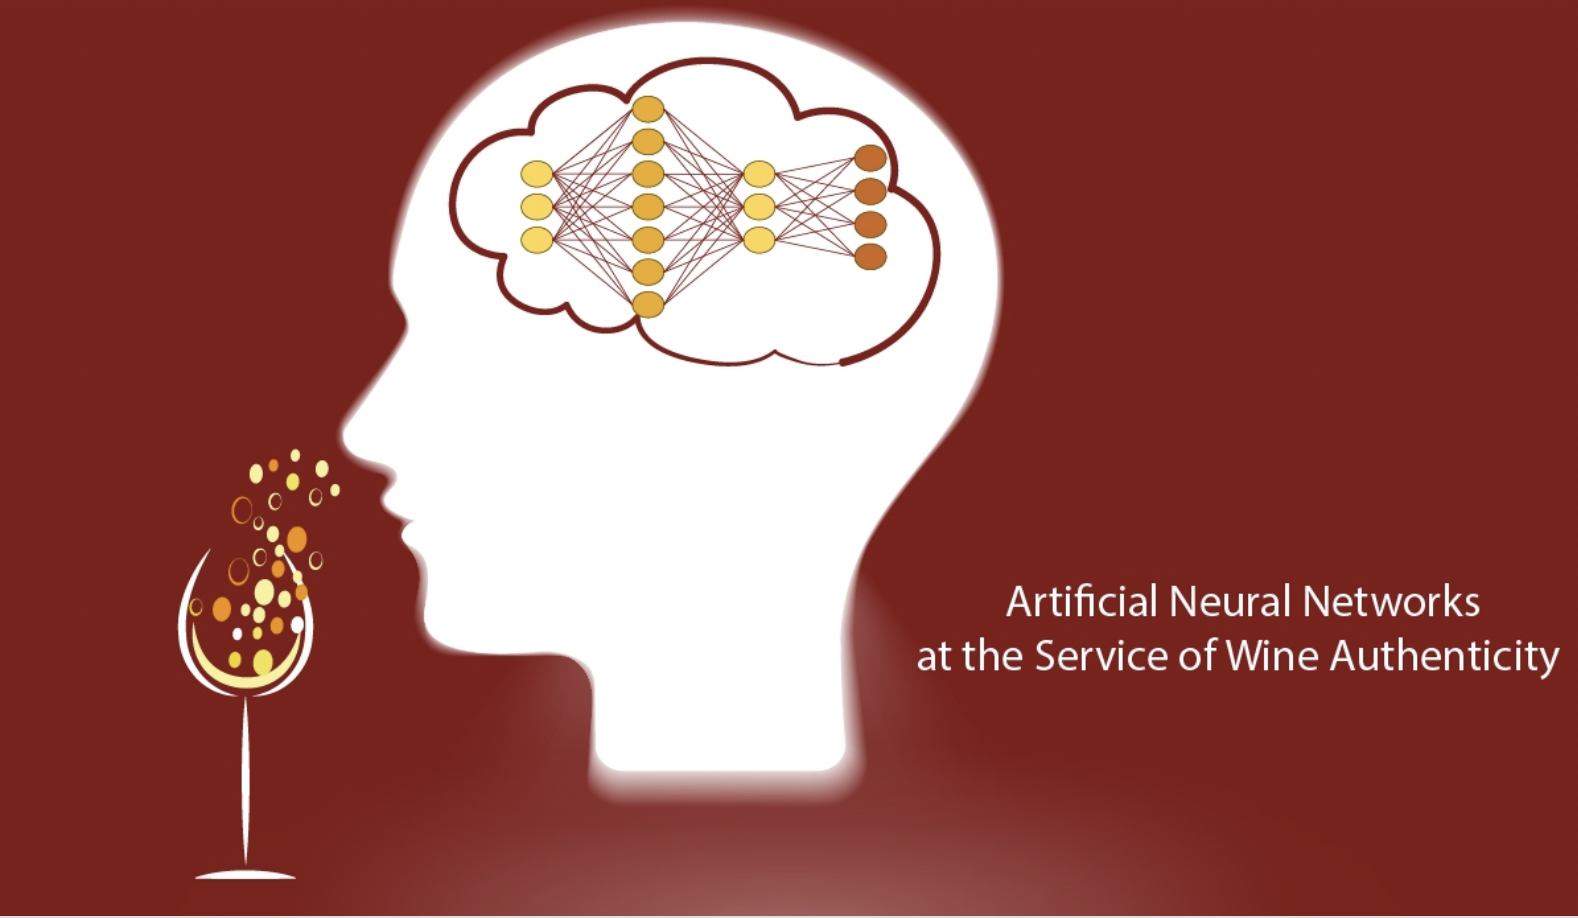
* In this lab, you will first train a neural network on a public dataset, then make several enhancements to the lab.
* Tasks breakdown:
  * Code running: 10%
  * Enhancement 1: 15%
  * Enhancement 2: 15%
  * Enhancement 3: 10%
  * Enhancement 4: 10%
  * Enhancement 5: 40%


## Imports

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Dataset

In [2]:
data_df = pd.read_csv('winequality-red.csv')

In [3]:
data_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# how many features?
len(data_df.columns) - 1

11

In [5]:
# how many labels? If yours is a binary classification task, then you'll have 2 labels.
data_df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [6]:
# convert these quaity measures to labels (0 to 5)
def get_label(quality):
    if quality == 3:
        return 0
    elif quality == 4:
        return 1
    elif quality == 5:
        return 2
    elif quality == 6:
        return 3
    elif quality == 7:
        return 4
    else:
        return 5

labels = data_df['quality'].apply(get_label)

# normalize data
data_df = (data_df - data_df.mean()) / data_df.std()
data_df['label'] = labels

In [7]:
data_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576,2
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,-0.787576,2
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,-0.787576,2
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,0.450707,3
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576,2


In [8]:
# sumamry statistics of the data
data_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1599.000000
mean,3.554936e-16,1.688594e-16,-1.066481e-16,-1.110917e-16,2.132961e-16,-6.221137e-17,2.666202e-17,-3.469617e-14,2.861723e-15,6.665504e-16,7.109871e-17,6.221137e-17,2.636023
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.807569
min,-2.136377e+00,-2.277567e+00,-1.391037e+00,-1.162333e+00,-1.603443e+00,-1.422055e+00,-1.230199e+00,-3.537625e+00,-3.699244e+00,-1.935902e+00,-1.898325e+00,-3.264143e+00,0.000000
25%,-7.004996e-01,-7.696903e-01,-9.290275e-01,-4.530767e-01,-3.711129e-01,-8.484502e-01,-7.438076e-01,-6.075656e-01,-6.549356e-01,-6.380200e-01,-8.661079e-01,-7.875763e-01,2.000000
50%,-2.410190e-01,-4.367545e-02,-5.634264e-02,-2.402999e-01,-1.798892e-01,-1.792441e-01,-2.574163e-01,1.759533e-03,-7.210449e-03,-2.250577e-01,-2.092427e-01,4.507074e-01,3.000000
75%,5.056370e-01,6.264921e-01,7.650078e-01,4.340257e-02,5.382858e-02,4.899619e-01,4.721707e-01,5.766445e-01,5.757422e-01,4.238832e-01,6.352984e-01,4.507074e-01,3.000000
max,4.353787e+00,5.876138e+00,3.742403e+00,9.192806e+00,1.112355e+01,5.365606e+00,7.372847e+00,3.678904e+00,4.526866e+00,7.916200e+00,4.201138e+00,2.927275e+00,5.000000


## Load this dataset for training a neural network

In [9]:
# The dataset class
class WineDataset(Dataset):

    def __init__(self, data_df):
        self.data_df = data_df
        self.features = []
        self.labels = []
        for _, i in data_df.iterrows():
          self.features.append([i['fixed acidity'], i['volatile acidity'], i['citric acid'], i['residual sugar'], i['chlorides'], i['free sulfur dioxide'], i['total sulfur dioxide'], i['density'], i['pH'], i['sulphates'], i['alcohol']])
          self.labels.append(i['label'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = self.features[idx]
        features = torch.FloatTensor(features)

        labels = torch.tensor(self.labels[idx], dtype = torch.long)

        return {'labels': labels, 'features': features}

wine_dataset = WineDataset(data_df)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(wine_dataset, [0.8, 0.1, 0.1])

# The dataloader
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False, num_workers = 0)

In [10]:
# peak into the dataset
for i in wine_dataset:
  print(i)
  break

{'labels': tensor(2), 'features': tensor([-0.5282,  0.9616, -1.3910, -0.4531, -0.2436, -0.4660, -0.3790,  0.5581,
         1.2882, -0.5790, -0.9599])}


## Neural Network

In [11]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

        self.linear1 = torch.nn.Linear(11, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 6)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

winemodel = WineModel().to(device)

## Training

In [27]:
# Define and the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(winemodel.parameters(), lr = 1e-3)

In [28]:
# Lets define the training steps
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1).flatten()
    labels = labels.flatten()
    return torch.sum(preds == labels) / len(labels)

def train(model, data_loader, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for d in tqdm(data_loader):
    inputs = d['features'].to(device)
    labels = d['labels'].to(device)
    outputs = winemodel(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = criterion(outputs, labels)
    acc = accuracy(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# Lets define the testing steps
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
      for d in data_loader:
        inputs = d['features'].to(device)
        labels = d['labels'].to(device)
        outputs = winemodel(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
# Let's train our model
for epoch in range(100):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

# Lab Enhancements
* These tasks are additional enhancements with less guidance.
* Report results means give us the accuracy, precision, recall and F1-score.


## Enhancement 1: The current code does not actually evaluate the model on the test set, but it only evaluates it on the val set. When you write papers, you would ideally split the dataset into train, val and test. Train and val are both used in training, and the model trained on the training data, and  evaluated on the val data. So why do we need test split? We report our results on the test split in papers. Also, we do cross-validation on the train/val split (covered in later labs).

## Report the results of the model on the test split. (Hint: It would be exactly like the evaluation on the val dataset, except it would be done on the test dataset.)

In [ ]:
test_loss, test_acc = somefunction(,,)
print(f'| Test. Loss: {test_loss:.3f} | Test. Acc: {test_acc*100:.2f}% |')

## Enhancement 2: Increase the number of epochs (and maybe the learning rate). Does the accuracy on the test set increase? Is there a significant difference between the test accuracy and the train accuracy? If yes, why?

## Enhancement 3: Increase the depth of your model (add more layers). Report the parts of the model definition you had to update. Report results.

## Enhancement 4: Increase the width of your model's layers. Report the parts of the model definition you had to update. Report results.

## Enhancement 5: Choose a new dataset from the list below. Search the Internet and download your chosen dataset (many of them could be available on kaggle). Adapt your model to your dataset. Train your model and record your results.

   * cancer_dataset          - Breast cancer dataset.
   * crab_dataset            - Crab gender dataset.
   * glass_dataset           - Glass chemical dataset.
   * iris_dataset            - Iris flower dataset.
   * ovarian_dataset         - Ovarian cancer dataset.
   * thyroid_dataset         - Thyroid function dataset.